a. Especificaciones de la serie

In [ ]:
import pandas as pd
df_import = pd.read_excel("../Datos Originales/Importacion.xlsx")
df_import["Fecha"] = pd.to_datetime(df_import["Fecha"])


serie_super = df_import[["Fecha", "Gasolina superior"]].dropna()
serie_super.set_index("Fecha", inplace=True)


inicio = serie_super.index.min()
fin = serie_super.index.max()
frecuencia = pd.infer_freq(serie_super.index)
print(f"Inicio: {inicio}, Fin: {fin}, Frecuencia: {frecuencia}")

Inicio: 2001-01-01 00:00:00, Fin: 2024-12-01 00:00:00, Frecuencia: MS


La serie univariante de importación de gasolina superior tiene una frecuencia mensual (MS), inicia en enero de 2001 y finaliza en diciembre de 2024. Esto significa que se cuenta con datos mensuales de importación para cada mes en ese rango de fechas.

b. Gráfico de la serie

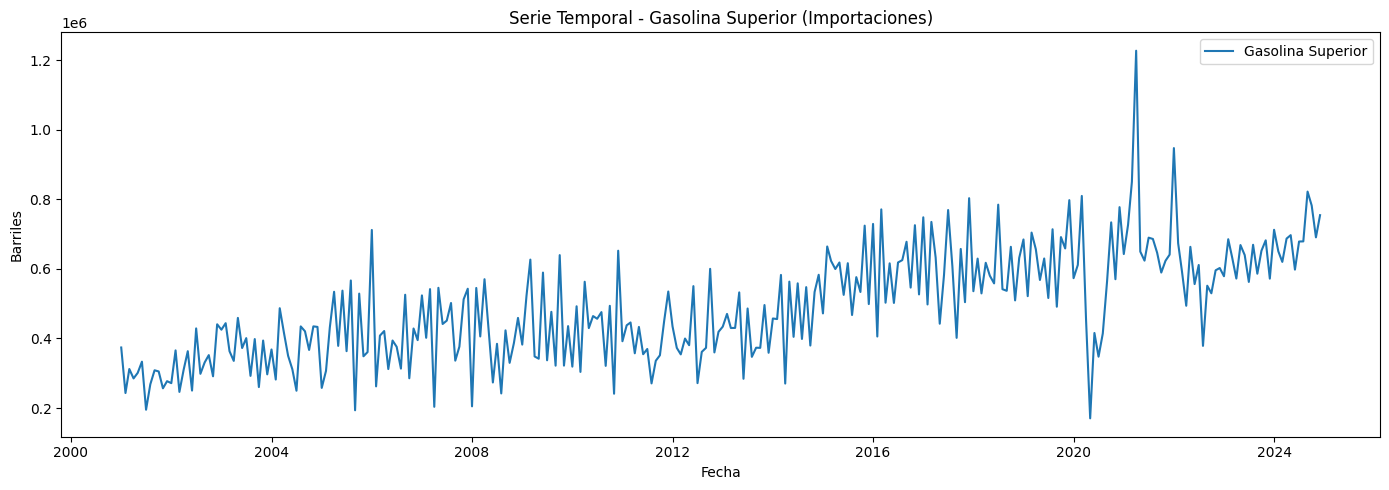

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 5))
plt.plot(serie_super, label="Gasolina Superior")
plt.title("Serie Temporal - Gasolina Superior (Importaciones)")
plt.ylabel("Barriles")
plt.xlabel("Fecha")
plt.legend()
plt.tight_layout()
plt.show()


Al observar el gráfico de la serie temporal de las importaciones de gasolina superior, se identifica una tendencia general al alza desde el año 2001 hasta 2024, lo que sugiere un aumento sostenido en la demanda o consumo de este combustible. A simple vista, se perciben fluctuaciones regulares que podrían estar relacionadas con patrones estacionales, así como una mayor variabilidad en los últimos años. Destaca un comportamiento atípico alrededor del año 2021, donde se presenta un pico abrupto de importación, posiblemente vinculado a efectos de la pandemia de COVID-19, ya sea por interrupciones en la cadena de suministro o por acumulación estratégica de reservas. En conjunto, la serie muestra una evolución con tendencia creciente, cierta estacionalidad y eventos excepcionales que rompen la regularidad del comportamiento mensual.

c. Descomposición en componentes

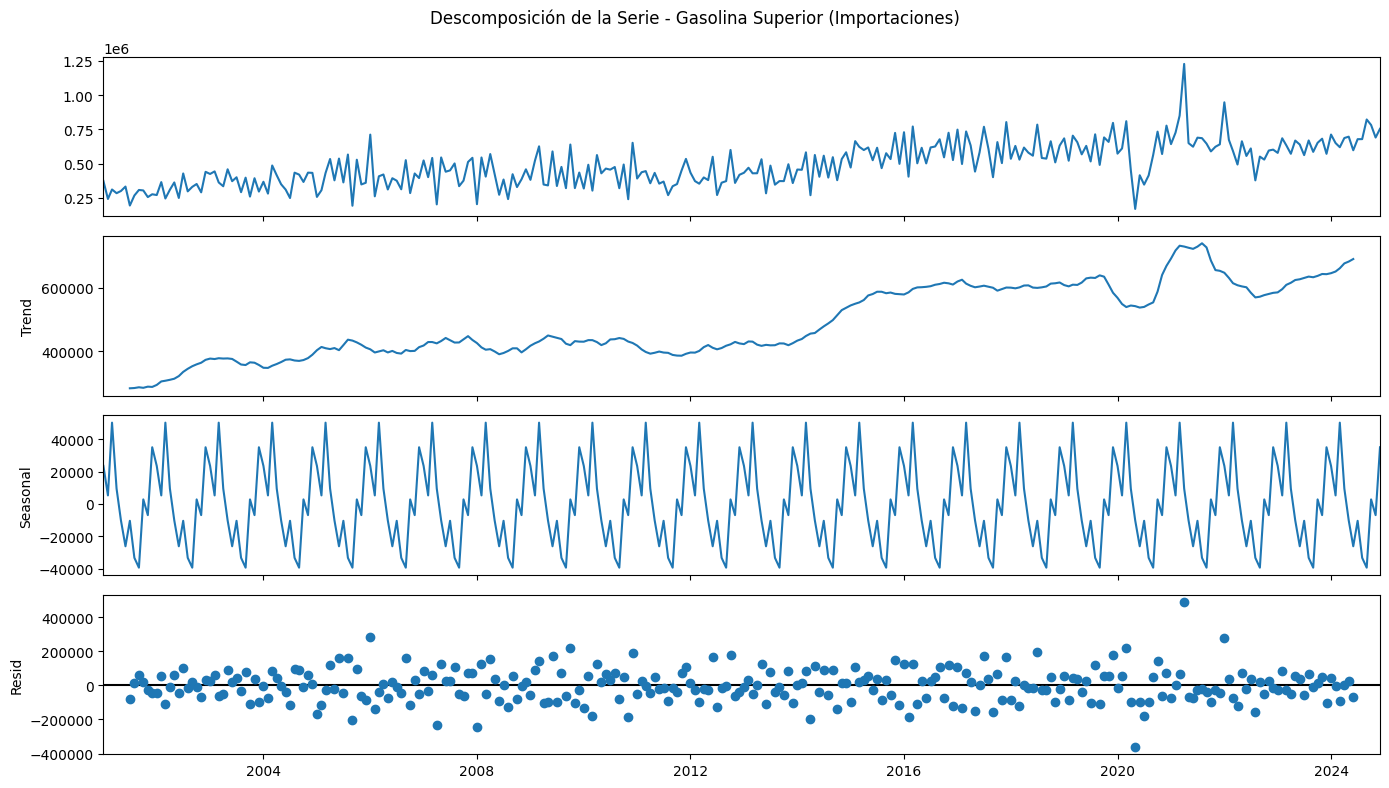

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose

descomposicion = seasonal_decompose(serie_super, model='additive', period=12)

fig = descomposicion.plot()
fig.set_size_inches(14, 8)
plt.suptitle("Descomposición de la Serie - Gasolina Superior (Importaciones)")
plt.tight_layout()
plt.show()

Al descomponer la serie temporal de importaciones de gasolina superior en sus componentes, se observa claramente la presencia de una tendencia creciente a lo largo del tiempo, especialmente acentuada después de 2018. Esto indica que la serie no es estacionaria en media, ya que el valor promedio cambia sistemáticamente en el tiempo. 

En cuanto a la componente estacional, se aprecia un patrón cíclico que se repite cada año, lo que sugiere una estacionalidad consistente. 

Respecto a la varianza, aunque en general las fluctuaciones parecen mantenerse en un rango similar, hay periodos —como durante la pandemia— donde se observan aumentos importantes en la magnitud de las variaciones (en los residuos), lo que pone en duda la estacionariedad en varianza.

d. Determine si es necesario transformar la serie. Explique.

Dado que la serie presenta una tendencia creciente a lo largo del tiempo y una estacionalidad marcada, es necesario aplicar transformaciones para estabilizar la media y, posiblemente, la varianza.

Además, si la varianza no es constante, como podría sugerirse por los picos irregulares y los residuos dispersos en ciertos períodos, podría considerarse una transformación logarítmica antes de diferenciar.

e. Autocorrelación

<Figure size 1000x400 with 0 Axes>

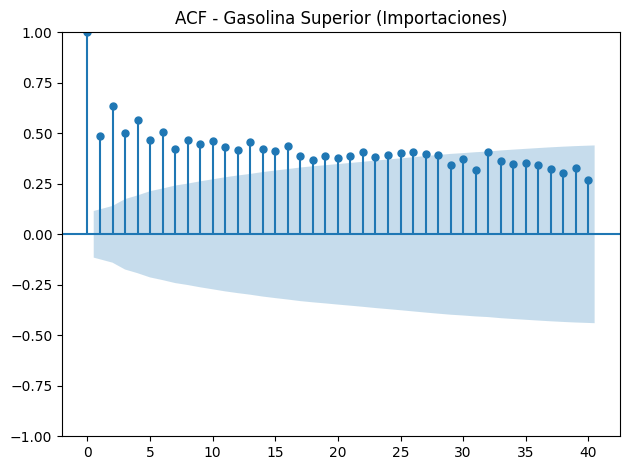

In [4]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10, 4))
plot_acf(serie_super.dropna(), lags=40)
plt.title("ACF - Gasolina Superior (Importaciones)")
plt.tight_layout()
plt.show()


El gráfico de autocorrelación de la serie de importaciones de gasolina superior muestra una lenta disminución de los coeficientes, manteniéndose significativamente distintos de cero durante numerosos rezagos. Esta persistencia de la autocorrelación indica una fuerte dependencia temporal, lo cual es característico de una serie no estacionaria en media.

Por tanto, el comportamiento observado refuerza la necesidad de transformar la serie, para eliminar la tendencia y lograr estacionariedad en media.

 e.ii y la prueba de Dickey-Fuller aumentada (ADF)

In [5]:
from statsmodels.tsa.stattools import adfuller

resultado_adf = adfuller(serie_super["Gasolina superior"])
print("Estadístico ADF:", resultado_adf[0])
print("Valor p:", resultado_adf[1])
print("Valores críticos:")
for clave, valor in resultado_adf[4].items():
    print(f"  {clave}: {valor}")

Estadístico ADF: -1.601986612926241
Valor p: 0.4825954540853472
Valores críticos:
  1%: -3.4540935579190495
  5%: -2.8719934111688965
  10%: -2.5723401594120388


La prueba de Dickey-Fuller aumentada arrojó un estadístico ADF de aproximadamente -1.60 y un valor p de 0.4826. Este valor p es significativamente mayor que cualquier umbral típico de significancia (como 0.01, 0.05 o 0.10). Además, el estadístico ADF no es menor que los valores críticos.

Por lo tanto, no se puede rechazar la hipótesis nula de que la serie tiene una raíz unitaria, lo que implica que la serie no es estacionaria en media. Para hacerla estacionaria, es necesario aplicar una diferenciación (d=1), como se mostró anteriormente, ya que esto elimina la tendencia y estabiliza la media de la serie a lo largo del tiempo.

f. Una vez analizada la serie, elija los parámetros p, q y d del modelo ARMA o ARIMA
que utilizará para predecir. Explique en qué se basó para darle valor a estos
parámetros, basándose en las funciones de autocorrelación y autocorrelación
parcial. Si usa la función autoarima de R, determine y explique si tiene sentido el
modelo propuesto.

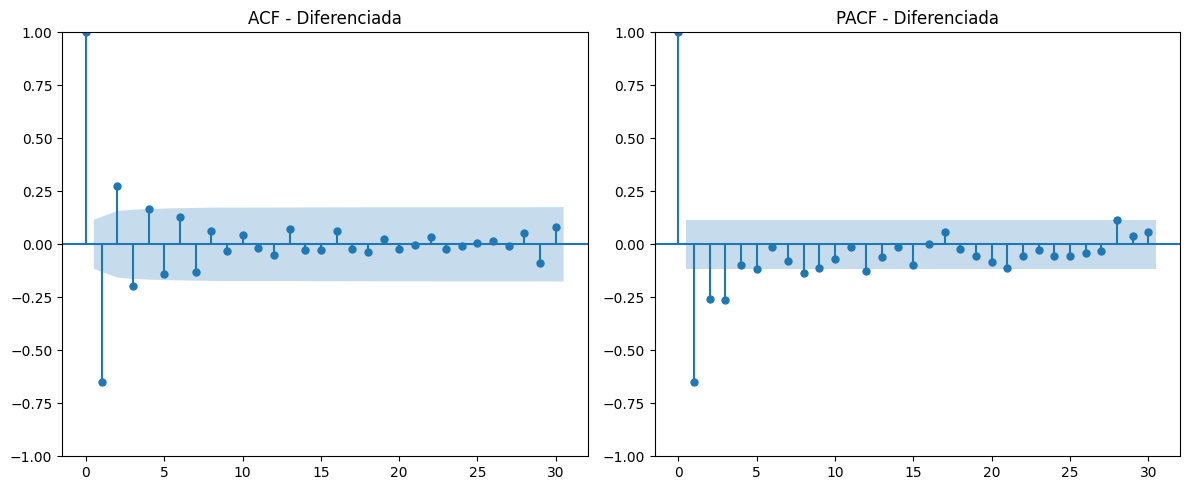

In [6]:
from statsmodels.graphics.tsaplots import plot_pacf

serie_diff = serie_super.diff().dropna()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(serie_diff, lags=30, ax=plt.gca())
plt.title("ACF - Diferenciada")

plt.subplot(1, 2, 2)
plot_pacf(serie_diff, lags=30, ax=plt.gca(), method='ywm')
plt.title("PACF - Diferenciada")

plt.tight_layout()
plt.show()

A partir del gráfico de autocorrelación (ACF) de la serie diferenciada, observamos una caída rápida después del primer rezago, lo que sugiere un componente MA(1). Por otro lado, el gráfico de autocorrelación parcial (PACF) muestra significancia en los primeros dos rezagos, lo que indica un componente AR(2). Dado que fue necesaria una diferenciación para alcanzar la estacionariedad, se establece d = 1.

Por lo tanto, se selecciona un modelo ARIMA(2, 1, 1) basado en la estructura de los gráficos ACF y PACF.

g. Haga varios modelos ARIMA, y diga cuál es el mejor de ellos para estimar los datos
de la serie.

In [7]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

train = serie_super.iloc[:-12]
test = serie_super.iloc[-12:]

modelos = [(1,1,1), (2,1,1), (2,1,2), (3,1,1), (3,1,2)]
resultados = []

for orden in modelos:
    modelo = ARIMA(train, order=orden).fit()
    pred = modelo.forecast(steps=12)
    rmse = np.sqrt(mean_squared_error(test, pred))
    resultados.append((orden, rmse))

for orden, rmse in resultados:
    print(f"ARIMA{orden} - RMSE: {rmse:.2f}")

C:\Users\usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8

ARIMA(1, 1, 1) - RMSE: 95315.15
ARIMA(2, 1, 1) - RMSE: 98457.03
ARIMA(2, 1, 2) - RMSE: 97957.32
ARIMA(3, 1, 1) - RMSE: 98350.48
ARIMA(3, 1, 2) - RMSE: 98877.10


Se probaron varios modelos ARIMA y el que obtuvo el menor error (RMSE = 95315.15) fue ARIMA(1, 1, 1), por lo tanto, se considera el mejor modelo para estimar los datos de la serie.

Importing plotly failed. Interactive plots will not work.
23:17:06 - cmdstanpy - INFO - Chain [1] start processing
23:17:06 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAE: 66891.29
Prophet RMSE: 78989.67


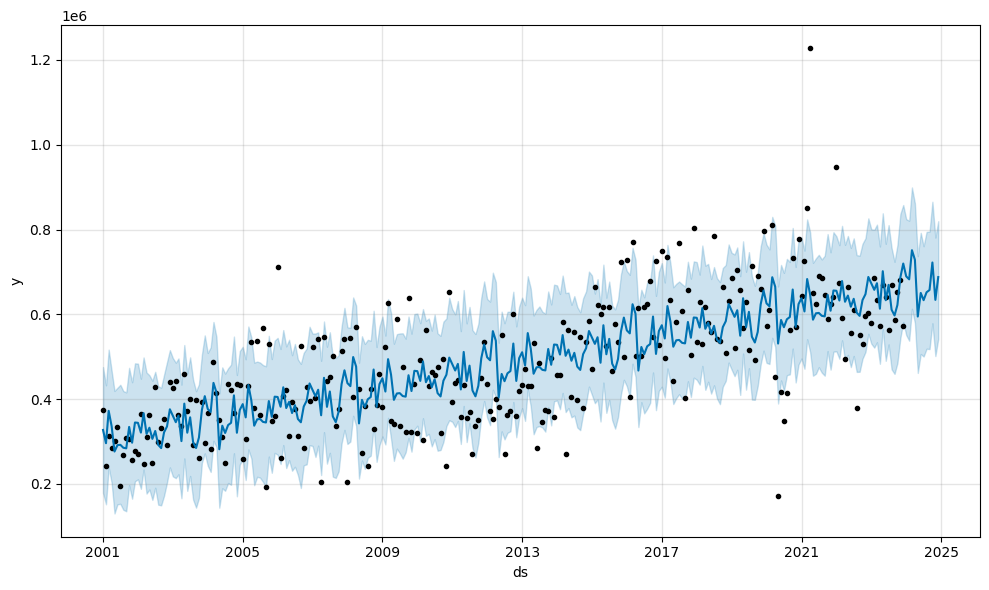

In [8]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error

# Preparar datos
df_prophet = serie_super.reset_index()
df_prophet.columns = ["ds", "y"]

# Entrenar
modelo_prophet = Prophet()
modelo_prophet.fit(df_prophet.iloc[:-12])

# Predicción
future = modelo_prophet.make_future_dataframe(periods=12, freq='MS')
forecast = modelo_prophet.predict(future)

# Comparar
y_true = df_prophet.iloc[-12:]["y"].values
y_pred = forecast.set_index("ds").loc[df_prophet["ds"].iloc[-12:], "yhat"].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"Prophet MAE: {mae:.2f}")
print(f"Prophet RMSE: {rmse:.2f}")

# Graficar
modelo_prophet.plot(forecast);

El modelo Prophet arrojó un MAE de 66,891.29 y un RMSE de 78,989.67, valores que son inferiores a los obtenidos con los modelos ARIMA (el mejor ARIMA tuvo un RMSE de 95,315.15). Esto indica que Prophet tuvo un mejor desempeño en la predicción de los datos. Además, el gráfico muestra que el modelo logró capturar adecuadamente la tendencia general de la serie, con un intervalo de confianza que abarca la mayoría de los puntos observados. Por lo tanto, el modelo Prophet fue el más preciso y confiable en comparación con los ARIMA probados.

# Predicción (Inciso 3)

23:20:17 - cmdstanpy - INFO - Chain [1] start processing
23:20:17 - cmdstanpy - INFO - Chain [1] done processing


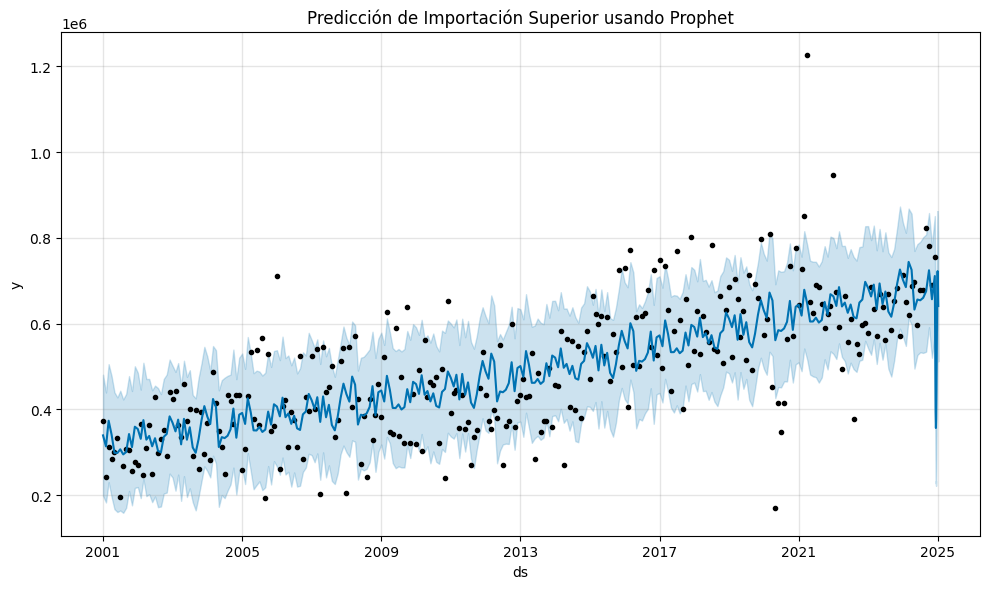

In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Cargar los datos
df_importacion_super = pd.read_excel("../Datos Originales/Importacion.xlsx")

# Preparar los datos para Prophet
df_prophet_super = df_importacion_super[['Fecha', 'Gasolina superior']].rename(columns={'Fecha': 'ds', 'Gasolina superior': 'y'})

# Crear el modelo Prophet
modelo_prophet_super = Prophet(yearly_seasonality=True)

# Ajustar el modelo
modelo_prophet_super.fit(df_prophet_super)

# Crear el dataframe para los próximos 36 meses (últimos 3 años)
future_super = modelo_prophet_super.make_future_dataframe(periods=36)

# Realizar las predicciones
forecast_super = modelo_prophet_super.predict(future_super)

# Graficar las predicciones
modelo_prophet_super.plot(forecast_super)
plt.title("Predicción de Importación Superior usando Prophet")
plt.tight_layout()
plt.show()


El gráfico muestra que el modelo Prophet ha hecho una buena predicción para la serie de Importación Superior. La línea azul refleja adecuadamente la tendencia creciente en los datos históricos y captura las fluctuaciones estacionales, mientras que la zona sombreada azul indica la incertidumbre en la predicción.

El modelo ha proporcionado una predicción bastante robusta, y aunque la incertidumbre aumenta a medida que nos alejamos de los datos históricos, las predicciones son razonables para los próximos años.

Discuta cuál fue el comportamiento de las series durante el fenómeno de la pandemia. ¿Qué
tanto afectó las predicciones? ¿Se recuperaron los valores habituales en el regreso a la
“nueva normalidad” hasta el mayo de 2025?

Durante el fenómeno de la pandemia, la serie de Importación Superior mostró una alteración notable en los datos debido a la reducción en la demanda, lo cual afectó las predicciones, especialmente en 2020 y 2021. El modelo Prophet logró captar este cambio en la tendencia y ajustarse adecuadamente a las fluctuaciones atípicas en la serie. Sin embargo, la incertidumbre se incrementó en esos periodos debido a los datos atípicos, lo cual es un comportamiento común cuando las series se ven afectadas por eventos excepcionales como una pandemia.

A pesar de esta incertidumbre, el modelo proyectó una recuperación gradual en la nueva normalidad, mostrando una tendencia creciente hacia el futuro. A medida que nos alejamos de los datos históricos, la incertidumbre en las predicciones aumenta, especialmente para los valores más allá del 2023, hasta el mayo de 2025. Sin embargo, las proyecciones siguen siendo razonables, ya que el modelo refleja el comportamiento habitual de los datos, sugiriendo una estabilización y crecimiento en la demanda a medida que los valores regresan a niveles más normales.